In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

In [8]:
#helper Method
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'darkblue'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.drop(columns=['id'], inplace=True)

In [10]:
# More Visualized EDA
# print(train_df.shape)
# train_df.head()

cols = train_df.columns.to_list()

display(set_frame_style(train_df[cols].head(),'First Few Rows Of Data'))

display(set_frame_style(train_df[cols].describe(),'Summary Statistics'))

display(set_frame_style(train_df[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), 'Unique Value Counts In Each Column'))

display(set_frame_style(train_df[cols].isna().any().to_frame().transpose(), 'Columns With Nan'))

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.610000,3.000000,2.000000,2.000000,2.000000,10.300000,1.000000,0.000000,32.000000,36509.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.090000
1,5.000000,2.000000,4.000000,0.000000,3.000000,6.660000,1.000000,0.000000,1.000000,28206.000000,1.000000,0.000000,0.000000,0.000000,0.000000,121.800000
2,14.080000,4.000000,0.000000,0.000000,3.000000,21.300000,1.000000,0.000000,26.000000,21215.000000,1.000000,0.000000,0.000000,0.000000,0.000000,83.510000
3,4.020000,3.000000,5.000000,0.000000,0.000000,14.800000,0.000000,1.000000,36.000000,21215.000000,1.000000,0.000000,0.000000,0.000000,0.000000,66.780000
4,2.130000,3.000000,5.000000,0.000000,3.000000,17.000000,1.000000,1.000000,20.000000,27694.000000,1.000000,1.000000,1.000000,1.000000,1.000000,111.510000


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
count,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000
mean,6.337376,3.043881,2.456482,0.689390,2.203813,13.822071,0.568086,0.327797,18.972706,28180.333442,0.564839,0.277394,0.504807,0.504832,0.503191,99.614729
std,3.307980,0.784676,1.488992,1.214732,1.084293,4.614792,0.495343,0.469411,10.212912,5968.874074,0.495779,0.447713,0.499978,0.499977,0.499991,29.939435
min,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.790000
25%,3.720000,3.000000,1.000000,0.000000,1.000000,9.710000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.320000
50%,5.780000,3.000000,2.000000,0.000000,2.000000,13.600000,1.000000,0.000000,20.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000,98.810000
75%,8.400000,4.000000,4.000000,1.000000,3.000000,17.700000,1.000000,1.000000,28.000000,33858.000000,1.000000,1.000000,1.000000,1.000000,1.000000,126.620000
max,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000,149.750000


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
Unique Value Count,1044,6,6,6,5,384,2,2,36,20,2,2,2,2,2,328


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


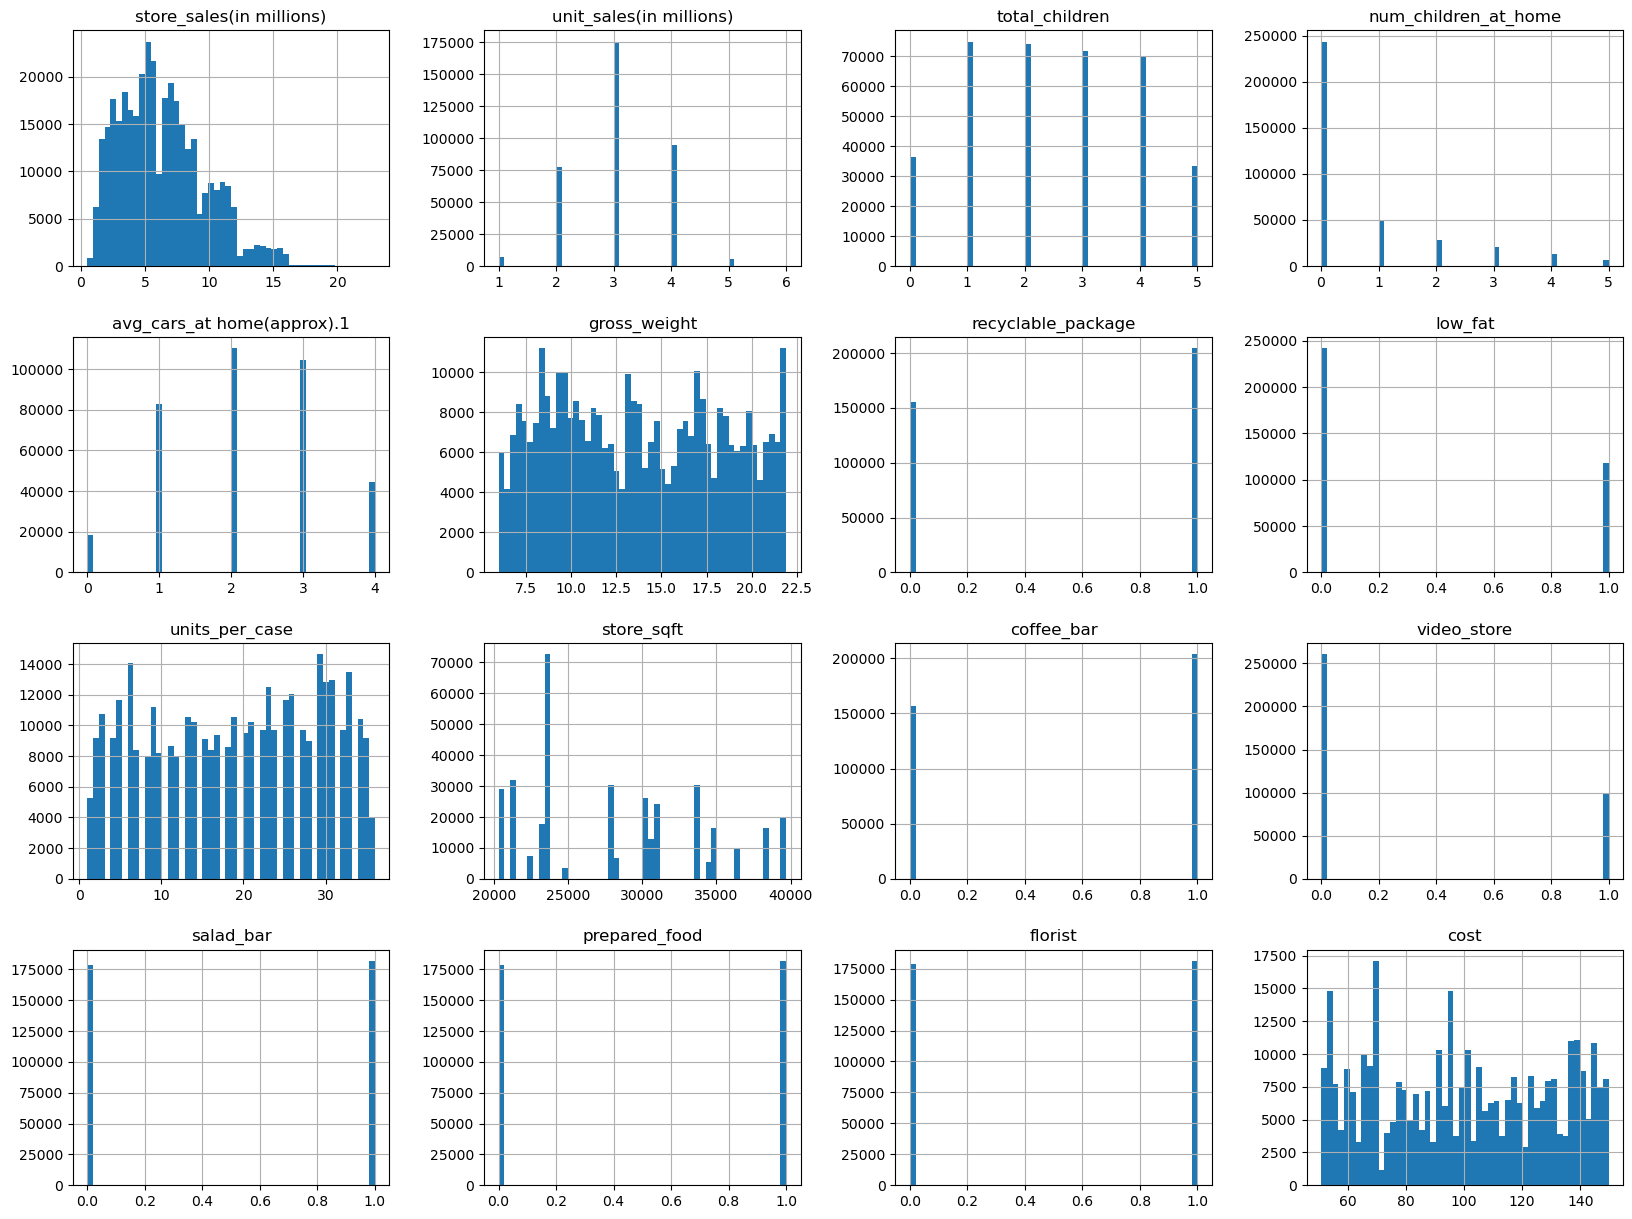

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt 

train_df.hist(bins=50, figsize=(20,15))
plt.show()

This dataset is made of continuous variables (e.g., gross_weight) and binary, categorical variables (e.g., video_store). It has already been numerized, so we can skip this step. 

Let's compute the standard correlation coefficient (pearson) between the cost and all the attributes using the `corr()` method. These coefficients range from -1 to 1 (1 = positively correlated, 0 = no correlation, -1 = negatively correlated)

In [12]:
corr_matrix = train_df.corr()
corr_matrix['cost'].sort_values(ascending=False)

cost                          1.000000
avg_cars_at home(approx).1    0.027098
units_per_case                0.000180
gross_weight                 -0.000116
recyclable_package           -0.001455
num_children_at_home         -0.001727
low_fat                      -0.001975
total_children               -0.007482
store_sales(in millions)     -0.012387
unit_sales(in millions)      -0.026509
store_sqft                   -0.049201
coffee_bar                   -0.052086
salad_bar                    -0.098810
prepared_food                -0.098843
video_store                  -0.106786
florist                      -0.110414
Name: cost, dtype: float64

They all have quite a low correlation coefficient, so they all seem individually unable to explain the cost.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


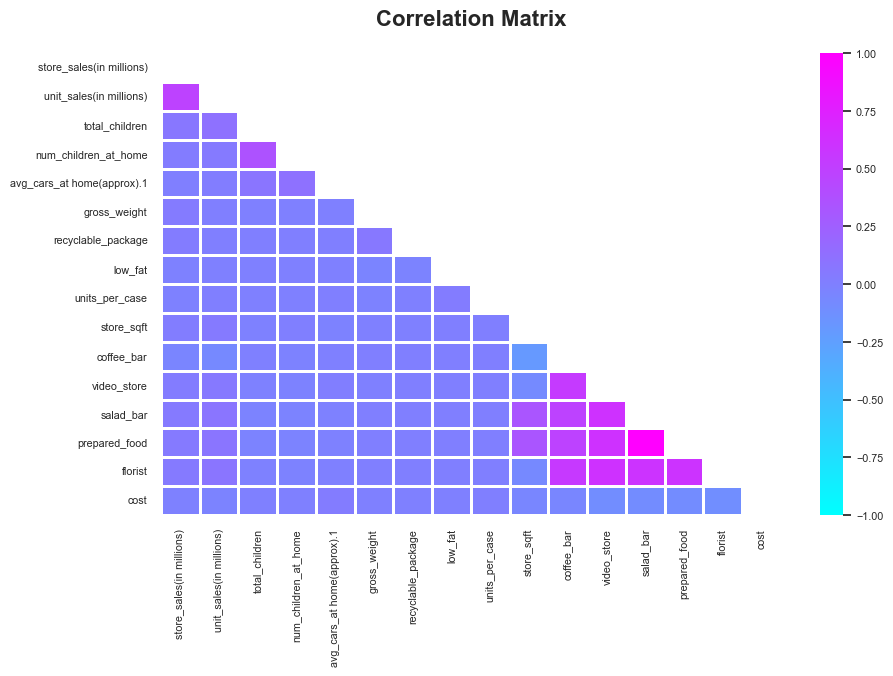

In [13]:
# create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create heatmap
plt.figure(figsize=(10, 6))
# set theme to change overall style
sns.set_theme(style="white", font_scale=0.7)
sns.heatmap(corr_matrix, cmap="cool", linewidths=2, mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation Matrix", fontsize=16, weight = 'bold', pad=20)
plt.show()

It looks like prepared_food and salad_bar are basically identical. We can then remove some features that have low correlation, some that are redundant, and I thank one of the guys in the discussion who found other feartures who are removable

In [14]:
selected_features = [
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'florist',
]

selected_features_test = [
    'id',
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'florist',
]


In [15]:
X = np.array(train_df[selected_features].values)
X_test = np.array(test_df[selected_features].values)

y = np.array(train_df['cost'])
print(X.shape)

(360336, 8)


Let's train our first scikit-learn linear regression. For this, we can use Scikit learn K-fold cross-validation feature, that randomly splits the training set into K disctinct subsets called folds, then it trains and evaluates the model K times, picking a different fold for evlauation every time and training on the other folds. The result is an array containing the K evaluation scores.  

In [16]:
from sklearn.linear_model import LinearRegression 
lin_reg = LinearRegression()
lin_reg.fit(X, y)

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_squared_log_error


rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

scores = cross_validate(lin_reg, X, y, scoring=rmsle_scorer, cv=5, return_train_score=True)

def display_rmse_scores(scores):
#     rmse_scores =  np.sqrt(-scores)
    print("Training score:", (-scores['train_score'].mean())**0.5)
    print("Validation score:", (-scores['test_score'].mean())**0.5)
display_rmse_scores(scores)

Training score: 0.31695175487141636
Validation score: 0.3169644619964467


We can now use Gradient Boosting. It works by sequentially adding predictors to an ensemble, each one correcting its predecessor. It particularly tries to fit the new predictor to the residual errors made by the previous predictor. Let's first split data into train and validation sets, as I don't want to use cross validation (takes too much time).

Note that the evaluation metric is RMSLE (Root Mean Squared Logarithmic Error), so transforming labels might yield better results since these regression models minimize loss functions on a MSE metric. 

In [17]:
from sklearn.model_selection import train_test_split 

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

In [18]:
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_log_error

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=5, warm_start=True)
gbrt.fit(X_train, np.log1p(y_train))


min_val_error = float("inf")
error_going_up = 0
# Let's gradually increase the number of estimators and check which model is best: perform early stopping with patience of 3 
for n_estimators in range(10, 100, 10):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, np.log1p(y_train))
    y_pred = np.expm1(gbrt.predict(X_val))
    val_error = mean_squared_log_error(y_val, y_pred)**0.5
    print("With "+str(n_estimators)+" estimators, val error = "+str(val_error))
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up=0
    else:
        error_going_up +=1
        if error_going_up==3:
            break # early stopping

With 10 estimators, val error = 0.312028980113256
With 20 estimators, val error = 0.3100294189673871
With 30 estimators, val error = 0.30867093195178175
With 40 estimators, val error = 0.3080524490125292
With 50 estimators, val error = 0.30761412443383956
With 60 estimators, val error = 0.30728889059339776
With 70 estimators, val error = 0.306982678879632
With 80 estimators, val error = 0.30670932583082916
With 90 estimators, val error = 0.3064700597700389


Not great, we can increase n_estimators to 1000 or more, but it will take a long time for not so much increase. Now let's try with XGBoost and early stopping with 20 of patience 

In [19]:
import xgboost as xgb
import optuna


#Train Extreme Gradient Boosting Model

#Create D-matrices for training and validation sets

DM_0=xgb.DMatrix(X_train,y_train)
DM_1=xgb.DMatrix(X_val,y_val)


glob_params = {
    'tree_method': 'hist',
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle',
    'n_estimators': 9999
}



def objective(trial):
    params = {
        'verbosity':0,
        'learning_rate': trial.suggest_float('learning_rate',1e-10,1.0),
        'max_depth':trial.suggest_int('max_depth', 3, 12),
#        'gamma':trial.suggest_float('gamma',0,8),
        'min_child_weight':trial.suggest_int('min_child_weight',0,1),
        'booster':trial.suggest_categorical("booster", ["dart", "gbtree",'gblinear']),
        'sampling_method': trial.suggest_categorical('sampling_method',['uniform','gradient_based']),
        'grow_policy': trial.suggest_categorical('grow_policy',['depthwise','lossguide']),
        'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
        'reg_lambda': trial.suggest_float("reg_lambda", 0, 1),
    }
    params.update(glob_params)
    sch_prm = xgb.train(params, DM_0, num_boost_round = 100,
                        evals = [(DM_1, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=False
                       )
    
    return sch_prm.best_score

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials = 500,)

# Simple XGBoost Params
best_params = {'n_estimators': 100, # not imp
             'learning_rate': 0.7, # + or - bad
             'max_depth': 12, # - bad + bad
             'lambda': 0.0150, # + bad 
             'alpha': 1.0e-08, # - is little good
             'colsample_bytree': 0.7, # imp (adding randomness to the training process.)
             'min_child_weight': 0, # + bad
             'booster': 'gbtree',
             'grow_policy': 'depthwise', 
             'tree_method': 'hist',
             'objective': 'reg:squaredlogerror',
             'eval_metric': 'rmsle',
             'random_state': 17}


# best_params.update(glob_params)

xgbr = xgb.train(
    dtrain=DM_0,
    num_boost_round=2000,
    params=best_params,
    early_stopping_rounds=20,
    evals=[(DM_0, 'train'), (DM_1, 'eval')],
    verbose_eval=True
)



[0]	train-rmsle:3.53438	eval-rmsle:3.53519
[1]	train-rmsle:3.10125	eval-rmsle:3.10204
[2]	train-rmsle:2.67940	eval-rmsle:2.68017
[3]	train-rmsle:2.27145	eval-rmsle:2.27220
[4]	train-rmsle:1.88089	eval-rmsle:1.88162
[5]	train-rmsle:1.51255	eval-rmsle:1.51324
[6]	train-rmsle:1.17349	eval-rmsle:1.17415
[7]	train-rmsle:0.87299	eval-rmsle:0.87355
[8]	train-rmsle:0.62507	eval-rmsle:0.62547
[9]	train-rmsle:0.44705	eval-rmsle:0.44719
[10]	train-rmsle:0.34908	eval-rmsle:0.34898
[11]	train-rmsle:0.31343	eval-rmsle:0.31313
[12]	train-rmsle:0.30531	eval-rmsle:0.30502
[13]	train-rmsle:0.30351	eval-rmsle:0.30314
[14]	train-rmsle:0.30272	eval-rmsle:0.30237
[15]	train-rmsle:0.30210	eval-rmsle:0.30181
[16]	train-rmsle:0.30175	eval-rmsle:0.30152
[17]	train-rmsle:0.29991	eval-rmsle:0.29974
[18]	train-rmsle:0.29816	eval-rmsle:0.29824
[19]	train-rmsle:0.29774	eval-rmsle:0.29786
[20]	train-rmsle:0.29772	eval-rmsle:0.29785


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:00:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	train-rmsle:0.29526	eval-rmsle:0.29563
[22]	train-rmsle:0.29410	eval-rmsle:0.29468
[23]	train-rmsle:0.29332	eval-rmsle:0.29407
[24]	train-rmsle:0.29309	eval-rmsle:0.29388
[25]	train-rmsle:0.29307	eval-rmsle:0.29385
[26]	train-rmsle:0.29300	eval-rmsle:0.29379
[27]	train-rmsle:0.29292	eval-rmsle:0.29373
[28]	train-rmsle:0.29289	eval-rmsle:0.29370
[29]	train-rmsle:0.29284	eval-rmsle:0.29368
[30]	train-rmsle:0.29282	eval-rmsle:0.29366
[31]	train-rmsle:0.29277	eval-rmsle:0.29363
[32]	train-rmsle:0.29276	eval-rmsle:0.29362
[33]	train-rmsle:0.29275	eval-rmsle:0.29361
[34]	train-rmsle:0.29271	eval-rmsle:0.29357
[35]	train-rmsle:0.29269	eval-rmsle:0.29357
[36]	train-rmsle:0.29264	eval-rmsle:0.29352
[37]	train-rmsle:0.29264	eval-rmsle:0.29351
[38]	train-rmsle:0.29251	eval-rmsle:0.29341
[39]	train-rmsle:0.29251	eval-rmsle:0.29341
[40]	train-rmsle:0.29249	eval-rmsle:0.29341
[41]	train-rmsle:0.29245	eval-rmsle:0.29339
[42]	train-rmsle:0.29223	eval-rmsle:0.29323
[43]	train-rmsle:0.29221	eval-rm

In [20]:

DM_test=xgb.DMatrix(X_test) 
submission_df = test_df['id']
prediction = xgbr.predict(DM_test)
pred_df = pd.DataFrame(prediction, columns=['cost'])
submission_df = pd.concat([test_df['id'], pred_df],axis=1).fillna(0)
submission_df.to_csv('cost_prediction.csv', index=False)

In [21]:
submission_df.head()

,id,cost
0,360336,90.401085
1,360337,93.663284
2,360338,94.554787
3,360339,98.659988
4,360340,78.232811
